# Problems

- Overfitting. Feature selection should be in the hundreds range not thousands
- IFDIF is including rows that were dropped for missing data
- Correlation is calculating nan
- race is wrong (was being overwritten by tfidf)
- Not all missing data was dropped

In [225]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys
import time

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import words

## Part a: Extracting Language Features

In [226]:
# the interview data (sheet 1)
interview_data = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx",
    sheet_name="Interview_Data",
    skiprows=lambda x: x == 1,
)
# drop the rows where data in column Partic# is NaN
interview_data = interview_data.dropna(subset=["Partic#"])
print(interview_data.tail())

# the phq score data (sheet 2)
phq_scores_data = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx", sheet_name="Metadata_mapping"
)

#Convert Participant_ID column to string
phq_scores_data['Participant_ID'] = phq_scores_data['Participant_ID'].astype(str)

#Convert PHQ_Score to int
phq_scores_data['PHQ_Score'] = phq_scores_data['PHQ_Score'].astype(int)

print(phq_scores_data.head())

     Partic# Condition  gender  race
428    837.0        AI     2.0     3
429    838.0        AI     1.0     1
430    839.0        AI     1.0     1
431    840.0        AI     2.0     3
432    841.0        AI     1.0     4
  Participant_ID  PHQ_Score
0            300          2
1            301          3
2            302          4
3            303          0
4            304          6


The following step was a workaround to prevent the end of file error due to unclosed inverted commas. What the code is doing - opening and reading each file, reading each line and checking for lines that start with " but does not end with " (i.e., checking for unclosed quotes).

In [227]:
# preprocessing the csv files to remove the unclosed inverted commas
def clean_csv(file_path, output_path):
    with open(file_path, "r") as infile, open(output_path, "w") as outfile:
        for line in infile:
            if line.startswith('"') and not line.endswith('"\n'):
                line = line[1:]
            outfile.write(line)


def process_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            clean_csv(input_path, output_path)


input_dir = "../data/E-DAIC_Transcripts"
output_dir = "../data/E-DAIC_Transcripts_cleaned"

process_directory(input_dir, output_dir)

In [228]:
cleaned_transcripts_path = "../data/E-DAIC_Transcripts_cleaned"

transcripts = {}

# loop through each file in the folder, load it, and store the content
for filename in os.listdir(cleaned_transcripts_path):
    if filename.endswith("_Transcript.csv"):
        participant_id = filename.split("_")[0]  # extract the participant id
        file_path = os.path.join(cleaned_transcripts_path, filename)

        df = pd.read_csv(file_path)
        transcripts[participant_id] = df

# transcripts
transcripts["386"]

,Text
0,might have pulled something that
1,I'm going to bring the great thanks so much
2,and please
3,are you okay with this yes
4,oh I'm fine I'm a little tired but I found ou...
...,...
76,yeah well after college people usually many p...
77,thank you goodbye
78,oh that was that was fast
79,but I didn't never said there wasn't any like...


In [229]:
# combine all the text data for each participant into a single string
combined_transcripts = {}

for participant_id, transcript in transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript["Text"].astype(str))

# removing extra spaces caused by newlines
for participant_id, transcript in combined_transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript.split())

# combined_transcripts

for participant_id, transcript in list(combined_transcripts.items())[:3]:
    print(participant_id, transcript)

423 okay and please yes feeling well where are you from originally Los Angeles the Greater Los Angeles area people diversity and various entertainment and activities fickle weather traffic and litter do you travel I have travel domestically not internationally seeing other places and how people live in the culture I want to hear about one of your trips the last trip that I went to a San Diego butt out from childhood or as an adult family vacations to Baja in Rosarito Beach can you tell me yeah the reason why that memory comes to mind because this weekend is Easter and we usually will go down to East Easter spring break to Rosarito Baja am I have a Bachelors in communication studies because of the open field just doesn't deal with them communication interactively but Performing Arts telecommunications business entrepreneurship so no I'm not at Maxey unemployed what's your dream job I think 200 my business that's my dream my dream job to have my own company I would like to open something

In [231]:
# combine the demographic data with the extracted text data

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# create the feature extractor objects here; using the base settings for now

corpus = list(combined_transcripts.values())
tfidf_vectorizer = TfidfVectorizer(stop_words="english", token_pattern=r"\b[A-Za-z]+\b")
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

sentiment_analyzer = SentimentIntensityAnalyzer()

combined_data = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # Extracting the PHQ score
        phq_score_row = phq_scores_data[phq_scores_data["Participant_ID"] == participant_id]
        if not phq_score_row.empty:
            phq_score = phq_score_row["PHQ_Score"].values[0]
        else:
            continue  # skip this participant if PHQ score is not found

        

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "RaceData": row["race"],
            "genderData": row["gender"],
            "phq_score": phq_score,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        # tfidf features
        tfidf_features = (
            tfidf_vectorizer.transform([transcript]).toarray().flatten()
        )  # has to be 1D array
        data.update(dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_features)))
        

        combined_data.append(data)

# convert the combined data into a dataframe
final_df = pd.DataFrame(combined_data)

'''
# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df = pd.concat([combined_data_df.reset_index(drop=True), tfidf_df], axis=1)
'''

print(final_df.head())
print(final_df.shape)


  participant_id  condition  RaceData  genderData  phq_score  pos_sentiment  \
0            386        0.0         3         2.0         11          0.184   
1            387        0.0         1         1.0          2          0.285   
2            388        0.0         4         1.0         17          0.161   
3            389        0.0         1         1.0         14          0.116   
4            390        0.0         3         1.0          9          0.193   

   neu_sentiment  neg_sentiment   aa  aau  ...  zip  ziplining  zipping  \
0          0.770          0.046  0.0  0.0  ...  0.0        0.0      0.0   
1          0.665          0.050  0.0  0.0  ...  0.0        0.0      0.0   
2          0.769          0.070  0.0  0.0  ...  0.0        0.0      0.0   
3          0.827          0.057  0.0  0.0  ...  0.0        0.0      0.0   
4          0.740          0.067  0.0  0.0  ...  0.0        0.0      0.0   

   zodiac  zoloft  zombie  zone  zuma  zurich   zz  
0     0.0     0.0    

- By removing common stop words and number, we went from $8702$ features to $8299$ features. We need to investigate how this affects the accuracy.
- Each term in the `TF-IDF` vector is considered a feature. The values represent the `TF-IDF` score for that term. A higher score could mean that the term is important to the transcript but not common in the entire list of transcripts. This is helpful in identifying the transcript's topic/sentiment.
- Initially, I decided on using the compound score, but that resulting list of scores are heavily skewed. Figuring something might be wrong, I reverted back to using individual metrics (positive, negative and neutral)

I noticed that using `CountVectorizer` just adds $8299$ more columns to the dataframe, making the already sparse dataset more sparse. Therefore, I decided to not use it.

In [232]:
# looking at the top 10 words with the highest tf-idf scores

feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df = pd.DataFrame({"feature": feature_names, "score": tfidf_scores})

# Sort the DataFrame by scores in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features = tfidf_scores_df.head(10)

# Display the top 10 features
print(top_10_features)

     feature      score
6326       s  35.261808
7293       t  32.736003
4428       m  29.000342
4287    like  24.292047
4058    just  23.032052
4129    know  22.186805
2193     don  17.789652
5934  really  16.630834
3160    good  12.510597
7451   think  10.710480


In [233]:
corpus = list(combined_transcripts.values())

# create a TfidfVectorizer without removing stop words
vectorizer_no_stop_words = TfidfVectorizer(token_pattern=r"\b[A-Za-z]+\b")
vectorizer_no_stop_words.fit(corpus)
vocab_no_stop_words = set(vectorizer_no_stop_words.get_feature_names_out())

# create a TfidfVectorizer with stop_words='english'
vectorizer_with_stop_words = TfidfVectorizer(
    stop_words="english", token_pattern=r"\b[A-Za-z]+\b"
)
vectorizer_with_stop_words.fit(corpus)
vocab_with_stop_words = set(vectorizer_with_stop_words.get_feature_names_out())

# find the difference between the two vocabularies
removed_stop_words = vocab_no_stop_words - vocab_with_stop_words

print("Removed stop words number:", len(removed_stop_words))

Removed stop words number: 272


In [9]:
""" # creating 5 folds with shuffled data

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(final_df):
    train_fold = final_df.iloc[train_index]
    test_fold = final_df.iloc[test_index]
    folds.append((train_fold, test_fold))

# display the first fold
# train_fold, test_fold = folds[0]
# print("Train Fold:")
# print(train_fold.head())
# print("\nTest Fold:")
# print(test_fold.head())

for i, (train_fold, test_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n") """

' # creating 5 folds with shuffled data\n\nfrom sklearn.model_selection import KFold\n\n# initialize the KFold object with 5 splits\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\n\nfolds = []\n\n# split the DataFrame into 5 folds\nfor train_index, test_index in kf.split(final_df):\n    train_fold = final_df.iloc[train_index]\n    test_fold = final_df.iloc[test_index]\n    folds.append((train_fold, test_fold))\n\n# display the first fold\n# train_fold, test_fold = folds[0]\n# print("Train Fold:")\n# print(train_fold.head())\n# print("\nTest Fold:")\n# print(test_fold.head())\n\nfor i, (train_fold, test_fold) in enumerate(folds):\n    print(f"Fold {i+1}:")\n    print(f"Train Fold Size: {len(train_fold)}")\n    print(f"Test Fold Size: {len(test_fold)}\n") '

### Optional: Doing more preprocessing to remove non-English words

_I used the NLTK library to exclude non-English words from the corpus. This reduces the number of features significantly, as you'll see below. I'm still not sure about removing the stop words though; you can try and see if disabling it helps with the performance._

_You can use this dataset to do the rest of the tasks. I only included this because I figured it might help with overfitting and consequentially, improve the model accuracies._

_For the folds, I have used the `final_df` dataset, which is the one that has $8306$ features. If you want, you can use the dataframe with the non-English words removed._

In [65]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download("words")

eng_words = set(words.words())

# preprocessing function


def preprocess_text(text):
    text = re.sub(r"\d+", "", text)  # Remove numbers
    tokens = re.findall(r"\b\w+\b", text)  # Tokenize
    valid_words = [
        token for token in tokens if token.lower() in eng_words
    ]  # Filter non-English words
    return " ".join(valid_words)


# create the feature extractor objects here; using the base settings for now

# corpus = list(combined_transcripts.values())
processed_corpus = [preprocess_text(text) for text in corpus]
tfidf_vectorizer_ = TfidfVectorizer(stop_words="english")
tfidf_matrix_ = tfidf_vectorizer_.fit_transform(processed_corpus)

sentiment_analyzer_ = SentimentIntensityAnalyzer()

combined_data_ = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "race": row["race"],
            "genderData": row["gender"],
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data_.append(data)

# convert the combined data into a dataframe
combined_data_df_ = pd.DataFrame(combined_data_)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df_ = pd.DataFrame(
    tfidf_matrix_.toarray(), columns=tfidf_vectorizer_.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df_ = pd.concat([combined_data_df_.reset_index(drop=True), tfidf_df_], axis=1)

final_df_.head()

[nltk_data] Downloading package words to /Users/zaneperry/nltk_data...
[nltk_data]   Package words is already up-to-date!


,participant_id,condition,race,genderData,pos_sentiment,neu_sentiment,neg_sentiment,aa,abandoned,ability,...,youth,yule,zany,zero,zest,zip,zipping,zodiac,zombie,zone
0,386,WoZ,3,2.0,0.184,0.770,0.046,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,0.285,0.665,0.050,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,0.161,0.769,0.070,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,0.116,0.827,0.057,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,0.193,0.740,0.067,0.0,0.068101,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By excluding non-english words, along with removing stop words, I was able to reduce the number of features significantly - from $8299$ to $5327$. This may produce better results.

In [41]:
feature_names_ = tfidf_vectorizer_.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores_ = np.sum(tfidf_matrix_.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df_ = pd.DataFrame({"feature": feature_names_, "score": tfidf_scores_})

# Sort the DataFrame by scores in descending order
tfidf_scores_df_ = tfidf_scores_df_.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features_ = tfidf_scores_df_.head(10)

# Display the top 10 features
print(top_10_features_)

     feature      score
2752    like  29.028222
2612    just  27.465559
2650    know  26.661350
1405     don  21.508594
3770  really  19.885133
2048    good  14.995024
4768   think  12.867584
3400  people  12.553898
4795    time  12.395769
2044   going  11.075604


## Part b: Classifying by Gender

In [ ]:
useNonEnglishWordRemovalDatasetFlag = False

if useNonEnglishWordRemovalDatasetFlag:
    genderDF = final_df_.drop(["race", "condition", "participant_id", "phq_score"], axis=1)
else:
    genderDF = final_df.drop(["race", "condition", "participant_id", "phq_score"], axis=1)

genderDF = genderDF.dropna()

# map gender from [1,2] -> [0,1] (XGBoost needs the labels to be 0 or 1)
genderDF["genderData"] = genderDF["genderData"].map({1: 0, 2: 1})

targetGender = genderDF.pop("genderData")

In [ ]:
from scipy.stats import pearsonr

genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    genderCorr.append(corr)

nan


In [ ]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

genderFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(genderDF):
    train_fold = genderDF.iloc[train_index]
    test_fold = genderDF.iloc[test_index]
    train_target_fold = targetGender.iloc[train_index]
    test_target_fold = targetGender.iloc[test_index]
    genderFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 105
Test Fold Size: 27

Fold 2:
Train Fold Size: 105
Test Fold Size: 27

Fold 3:
Train Fold Size: 106
Test Fold Size: 26

Fold 4:
Train Fold Size: 106
Test Fold Size: 26

Fold 5:
Train Fold Size: 106
Test Fold Size: 26



In [45]:
# helper function to calcualte accuracy and balanced accuracy
def getAccAndBAcc(yPred, yTrue):

    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0

    for idx in range(len(yPred)):
        
        if yPred[idx] == 1:

            if yTrue[idx] == 1:

                truePos += 1

            else:

                falseNeg += 1

        else:

            if yTrue[idx] == 1:

                falsePos += 1

            else:

                trueNeg += 1

    if (trueNeg+falsePos) == 0 and (truePos+falseNeg) != 0:
        balancedAccuracy = 0.5*truePos/(truePos+falseNeg)
    elif (trueNeg+falsePos) != 0 and (truePos+falseNeg) == 0:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos)
    else:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos) + 0.5*truePos/(truePos+falseNeg)
    
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falsePos + falseNeg)

    return accuracy, balancedAccuracy

In [46]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getDLModel(inputShape):

    model = Sequential([
        Dense(128, activation='relu', input_shape=(inputShape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

2024-12-05 23:49:02.050249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
import xgboost as xgb

#numberOfFeatures = [len(genderDF.columns)-1, 4000, 3000, 2000, 1000, 500]
numberOfFeatures = [5, 10, 25, 50, 100, 200, 500]

bAccTree = []
accTree  = []

bAccDL = []
accDL  = []

top_n_idx = lambda data, n: np.argsort(data)[-n:]

for n in numberOfFeatures:

    nIdx = top_n_idx(genderCorr, n)

    nCols = genderDF.columns[nIdx]

    foldAccTree = []
    foldBAccTree = []

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.fit(train_fold, train_target_fold)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(xgb_classifier.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=100, verbose=0)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(FNN.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))
    
    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━

# Part - C

In [50]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Attention, Flatten, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr

ModuleNotFoundError: No module named 'lightgbm'

In [13]:
def getAccAndBAcc_multi_class(yPred, yTrue):
    classes = np.unique(np.concatenate([yPred, yTrue]))
    recalls = []

    for cls in classes:
        # True Positives: Predicted and True are the same for this class
        truePos = np.sum((yPred == cls) & (yTrue == cls))
        # False Negatives: True is this class but Predicted is not
        falseNeg = np.sum((yPred != cls) & (yTrue == cls))
        # Compute recall for this class
        recall = truePos / (truePos + falseNeg) if (truePos + falseNeg) > 0 else 0
        recalls.append(recall)

    balancedAccuracy = np.mean(recalls)
    accuracy = np.mean(yPred == yTrue)

    return accuracy, balancedAccuracy


In [14]:
final_df.columns

Index(['participant_id', 'condition', 'race', 'genderData', 'pos_sentiment',
       'neu_sentiment', 'neg_sentiment', 'aa', 'aau', 'abandoned',
       ...
       'zip', 'ziplining', 'zipping', 'zodiac', 'zoloft', 'zombie', 'zone',
       'zuma', 'zurich', 'zz'],
      dtype='object', length=8306)

In [15]:
race_df = final_df.drop(["condition", "participant_id"], axis=1)
race_df = race_df.dropna()
y_race = race_df.pop("race")

In [16]:
race_df.shape, y_race.shape

((188, 8301), (188, 2))

In [17]:
y_race.columns = ["race", 'empty']
y_race = y_race.drop('empty', axis=1)
y_race = y_race - 1
y_race = y_race["race"]
y_race.shape

(188,)

In [18]:
def get_dense_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(7, activation="softmax")  # 7 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
race_folds = []

for train_index, test_index in skf.split(race_df, y_race):
    # print(train_index, test_index)
    train_fold = race_df.iloc[train_index]
    test_fold = race_df.iloc[test_index]
    train_target_fold = y_race.iloc[train_index]
    test_target_fold = y_race.iloc[test_index]
    race_folds.append((train_fold, train_target_fold, test_fold, test_target_fold))

In [20]:
race_corr = []

for i, (cols) in enumerate(race_df.columns):

    corr, p = pearsonr(race_df[cols], y_race)
    race_corr.append(corr)

0.34412850755041696

In [38]:
idx = np.argsort(race_corr)
idx = idx[::-1]

top10Cols = race_df.columns[idx[:20]].tolist()
top10Scores = np.sort(race_corr)
top10Scores = top10Scores[::-1]
top10Scores = top10Scores[:20]

print("Most Informative Features ")
for ii in range(20):
    print(f"{top10Cols[ii]}: {top10Scores[ii]}")

Most Informative Features 
married: 0.34412850755041696
engines: 0.2564705454265144
gulf: 0.2564434559285465
isolating: 0.2563003503627784
supporter: 0.2558775375819129
outstanding: 0.2557384734294923
acceptable: 0.251269288148262
flu: 0.2506673272894798
needy: 0.24853539782990497


In [21]:
for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):
    print(f"Fold {i + 1} - Train classes: {train_target_fold.unique()}, Test classes: {test_target_fold.unique()}")


Fold 1 - Train classes: [0 3 2 1 6 4 5], Test classes: [2 0 3 6 4 1]
Fold 2 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 0 1 2 6 4]
Fold 3 - Train classes: [2 0 3 6 1 4], Test classes: [2 0 3 6 1 5]
Fold 4 - Train classes: [2 3 0 6 1 4 5], Test classes: [0 2 3 1 6]
Fold 5 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 2 6 0 1 4]


In [22]:
numberOfFeatures = [len(race_df.columns)-1, 4000, 3000, 2000, 1000, 500]
top_n_idx = lambda data, n: np.argsort(np.abs(data))[-n:]

In [24]:
accTree = []
bAccTree = []

for n in numberOfFeatures:

    # Select top-n features based on correlation
    nIdx = top_n_idx(race_corr, n)
    nCols = race_df.columns[nIdx]
    # print(f"{n} features: {nCols}")  # Debug selected columns

    foldAccTree = []
    foldBAccTree = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        # Use only top-n columns
        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        train_data = lgb.Dataset(train_fold, label=train_target_fold)
        test_data = lgb.Dataset(test_fold, label=test_target_fold)

        # Define parameters
        params = {
            'objective': 'multiclass',
            'num_class': 7,
            'metric': 'multi_logloss',
            'is_unbalance': True,  # Address class imbalance
            'boosting_type': 'gbdt',
            'learning_rate': 0.1,
            'max_depth': 6,
            'num_leaves': 31,
            'verbose': -1
        }

        # Train LightGBM model
        lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)


        predictions = lgb_model.predict(test_fold)
        predicted_classes = predictions.argmax(axis=1)
        acc, bAcc = getAccAndBAcc_multi_class(predicted_classes, test_target_fold.to_numpy())

        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

    # Store mean accuracies across folds
    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))


In [25]:
bAccDL = []
accDL = []

for n in numberOfFeatures:

    # Select top-n features based on correlation
    nIdx = top_n_idx(race_corr, n)
    nCols = race_df.columns[nIdx]
    # print(f"{n} features: {nCols}")  # Debug selected columns

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        # Use only top-n columns
        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # Train Dense Neural Network
        FNN = get_dense_model(train_fold.shape[1])
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        ]
        # callbacks=callbacks,
        FNN.fit(train_fold, train_target_fold, validation_split=0.2, callbacks=callbacks, epochs=100,  verbose=0)

        # Evaluate Dense Neural Network
        fnn_predictions = FNN.predict(test_fold).argmax(axis=1)  # Convert probabilities to labels
        acc, bAcc = getAccAndBAcc_multi_class(fnn_predictions, test_target_fold.to_numpy())

        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

# Print results
# print(f"XGBoost Accuracy: {accTree}, Balanced Accuracy: {bAccTree}")
# print(f"Dense NN Accuracy: {accDL}, Balanced Accuracy: {bAccDL}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31c212290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━

In [26]:
print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")



#######################################
Values for 8300 top features:
Tree accuracy: 0.3085348506401138
Tree balanced accuracy: 0.1391540404040404
DL accuracy: 0.3143669985775249
DL balanced accuracy: 0.1733333333333333
#######################################
Values for 4000 top features:
Tree accuracy: 0.37268847795163584
Tree balanced accuracy: 0.19285606060606061
DL accuracy: 0.4095305832147938
DL balanced accuracy: 0.1733333333333333
#######################################
Values for 3000 top features:
Tree accuracy: 0.34651493598862027
Tree balanced accuracy: 0.17913383838383837
DL accuracy: 0.37268847795163584
DL balanced accuracy: 0.16611111111111113
#######################################
Values for 2000 top features:
Tree accuracy: 0.34651493598862027
Tree balanced accuracy: 0.17913383838383837
DL accuracy: 0.4095305832147938
DL balanced accuracy: 0.1733333333333333
#######################################
Values for 1000 top features:
Tree accuracy: 0.292176386913229
Tree ba

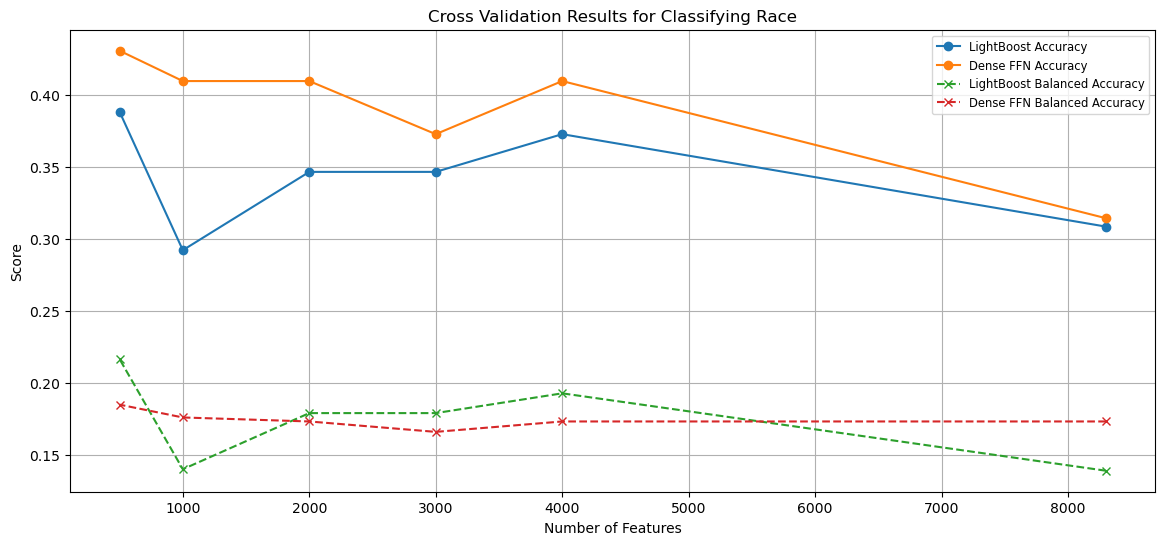

In [42]:
from matplotlib import pyplot as plt

# fig, ax = plt.subplots(2, figsize=(10, 8))
# fig.suptitle("Cross Validation Results For Classifying Race")
# ax[0].plot(numberOfFeatures, accTree, label="LightBoost")
# ax[0].plot(numberOfFeatures, accDL, label="Dense FFN")
# ax[0].set(xlabel="num of feats", ylabel="Accuracy")
# plt.legend()
#
# ax[1].plot(numberOfFeatures, bAccTree, label="LightBoost")
# ax[1].plot(numberOfFeatures, bAccDL, label="Dense FFN")
# ax[1].set(xlabel="num of feats", ylabel="Balanced Accuracy")
#
# plt.legend(loc='upper right', fontsize='small', ncol=2)
# plt.show()
plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying Race")

# Plot accuracy metrics
plt.plot(numberOfFeatures, accTree, label="LightBoost Accuracy", marker='o')
plt.plot(numberOfFeatures, accDL, label="Dense FFN Accuracy", marker='o')

# Plot balanced accuracy metrics
plt.plot(numberOfFeatures, bAccTree, label="LightBoost Balanced Accuracy", linestyle='--', marker='x')
plt.plot(numberOfFeatures, bAccDL, label="Dense FFN Balanced Accuracy", linestyle='--', marker='x')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

# Part D

In [234]:
from scipy.stats import pearsonr


'''
genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    genderCorr.append(corr)

'''

phqDF = final_df.drop(["RaceData", "condition", "participant_id", "genderData"], axis=1)

targetPHQ = phqDF.pop("phq_score")

phqCorr = []

for i, (cols) in enumerate(phqDF.columns):

    corr, p = pearsonr(phqDF[cols], targetPHQ)
    if np.isnan(corr):
        corr = 0
    phqCorr.append(corr)


def absRelErr(yPred, yTrue):
    return np.mean(np.abs(yPred - yTrue) / np.max(yTrue)), pearsonr(yPred, yTrue)[0]

In [118]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 107
Test Fold Size: 27

Fold 2:
Train Fold Size: 107
Test Fold Size: 27

Fold 3:
Train Fold Size: 107
Test Fold Size: 27

Fold 4:
Train Fold Size: 107
Test Fold Size: 27

Fold 5:
Train Fold Size: 108
Test Fold Size: 26



In [119]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getDLModel(inputShape):

    model = Sequential([
        Dense(64, activation='relu', input_shape=(inputShape,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation="linear")
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

In [126]:
import xgboost as xgb

numberOfFeatures = [50, 75, 100, 125, 150, 200, 500]

reTree = []
rTree  = []

reDL = []
rDL  = []

top_n_idx = lambda data, n: np.argsort(data)[-n:]

for n in numberOfFeatures:

    nIdx = top_n_idx(phqCorr, n)


    nCols = phqDF.columns[nIdx]

    foldReTree = []
    foldRTree = []

    foldReDL = []
    foldRDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):


        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_regressor = xgb.XGBRegressor()
        xgb_regressor.fit(train_fold, train_target_fold)

        relErr, r = absRelErr(xgb_regressor.predict(test_fold), test_target_fold.to_numpy())
        

        # store accuracies
        foldReTree.append(relErr)
        foldRTree.append(r)



        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=100, verbose=0)

        # get test accuracy and balanced accuracy
        
        relErr, r = absRelErr(FNN.predict(test_fold).flatten(), test_target_fold.to_numpy())

        # store accuracies
        foldReDL.append(relErr)
        foldRDL.append(r)
        


    reTree.append(np.mean(foldReTree))
    rTree.append(np.mean(foldRTree))
    
    reDL.append(np.mean(foldReDL))
    rDL.append(np.mean(foldRDL))

print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree Absolute Relative Error: {reTree[idx]}")
    print(f"Tree Pearson Coefficient: {rTree[idx]}")
    print(f"DL Absolute Relative Error: {reDL[idx]}")
    print(f"DL Pearson Coefficient: {rDL[idx]}")


minTreeReNumFeatures = numberOfFeatures[np.argmin(reTree)]
minDLReNumFeatures = numberOfFeatures[np.argmin(reDL)]

print("\n")
print("#######################################")
print(f"Min Tree Number of Features: {minTreeReNumFeatures}, with Absolute Relative Error of {np.min(reTree)}")
print(f"Min DL Number of Features: {minDLReNumFeatures}, with Absolute Relative Error of {np.min(reDL)}")
print("#######################################")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

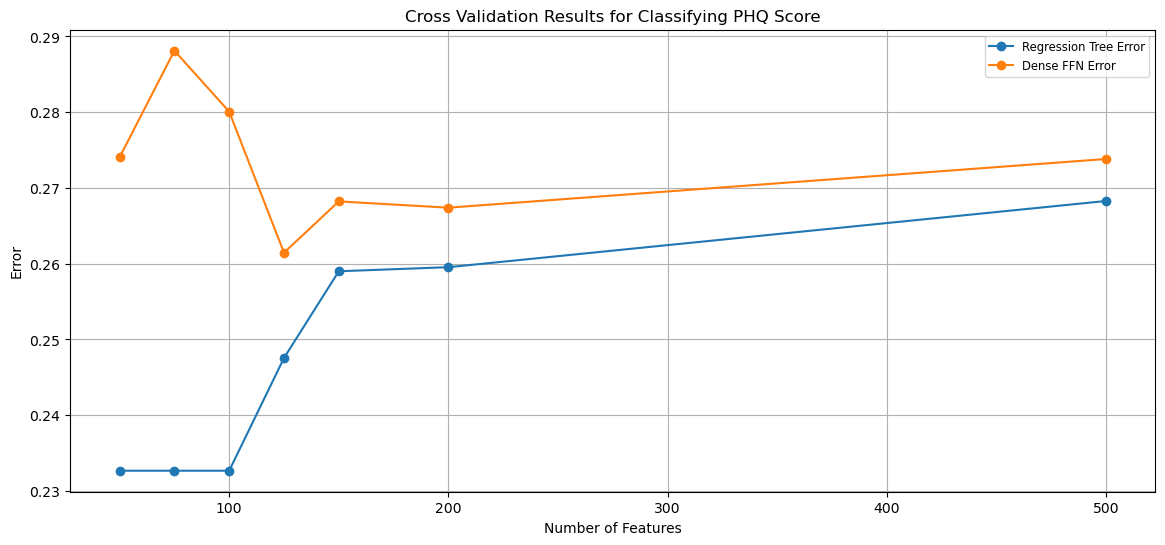

In [127]:
from matplotlib import pyplot as plt

# fig, ax = plt.subplots(2, figsize=(10, 8))
# fig.suptitle("Cross Validation Results For Classifying Race")
# ax[0].plot(numberOfFeatures, accTree, label="LightBoost")
# ax[0].plot(numberOfFeatures, accDL, label="Dense FFN")
# ax[0].set(xlabel="num of feats", ylabel="Accuracy")
# plt.legend()
#
# ax[1].plot(numberOfFeatures, bAccTree, label="LightBoost")
# ax[1].plot(numberOfFeatures, bAccDL, label="Dense FFN")
# ax[1].set(xlabel="num of feats", ylabel="Balanced Accuracy")
#
# plt.legend(loc='upper right', fontsize='small', ncol=2)
# plt.show()
plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying PHQ Score")

# Plot accuracy metrics
plt.plot(numberOfFeatures, reTree, label="Regression Tree Error", marker='o')
plt.plot(numberOfFeatures, reDL, label="Dense FFN Error", marker='o')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Error")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

In [ ]:
#Looking for subgroup accuracy using the best model

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqDF = final_df.drop(["race", "condition", "genderData"], axis=1)

targetPHQ = pd.DataFrame([phqDF.pop("participant_id"), phqDF.pop("phq_score").astype(int)]).T

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]["phq_score"]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))





minDLReNumFeatures = 125
minTreeReNumFeatures = 50


nIdxTree = top_n_idx(phqCorr, minTreeReNumFeatures)
nColsTree = phqDF.columns[nIdxTree]

nIdxDL = top_n_idx(phqCorr, minDLReNumFeatures)
nColsDL = phqDF.columns[nIdxDL]

# Iterate through the folds and actually store the predicition for each participant

predictionsDF = pd.DataFrame(columns=["participant_id", "phq_score_tree", "phq_score_dl"])

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):

    #match the predictions with the participant ID

    train_fold_tree = train_fold[nColsTree]
    test_fold_tree = test_fold[nColsTree]

    
    # train XGBoost model
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(train_fold_tree, train_target_fold)


    predTree = xgb_regressor.predict(test_fold_tree)
    
    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_tree"] = predTree


    # train DL model

    train_fold_dl = train_fold[nColsDL]
    test_fold_dl = test_fold[nColsDL]

    FNN = getDLModel(train_fold_dl.shape[1])

    FNN.fit(train_fold_dl.astype(float), train_target_fold.astype(float), epochs=100, verbose=0)

    predDL = FNN.predict(test_fold_dl).flatten()

    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_dl"] = predDL

    predictionsDF = pd.concat([predictionsDF, test_target_fold], axis=0)

# predDF
print(predictionsDF.head(30))

In [ ]:
predictionsDF = predictionsDF.sort_values(by=["participant_id"])

#combine the predictions with the demographic data

#create a dataframe to store the predictions. Has participant ID, race, gender, PHQ score, and the predicted PHQ score for both models
predDF = final_df[["participant_id", "RaceData", "genderData", "phq_score"]]

predDF = pd.merge(predDF, predictionsDF, on="participant_id")

#map race from number to label
raceMap = {
    1: "African American",
    2: "Asian",
    3: "White/Caucasian",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Oth Pacific Islander",
    7: "Other"
}

genderMap = {
    1: "Male",
    2: "Female"
}

#apply mapping to dataframe
predDF["RaceData"] = predDF["RaceData"].astype(int).map(raceMap)
predDF["genderData"] = predDF["genderData"].map(genderMap)

print(predDF.head())



   participant_id          RaceData genderData  phq_score_x  phq_score_tree  \
0             386   White/Caucasian     Female           11        1.008015   
1             387  African American       Male            2        2.096476   
2             388          Hispanic       Male           17        6.193720   
3             389  African American       Male           14        3.731840   
4             390   White/Caucasian       Male            9        0.311399   
5             391          Hispanic     Female            9        2.402858   
6             392   White/Caucasian     Female            1        2.972956   
7             393          Hispanic       Male            2        0.126626   
8             395          Hispanic     Female            7        5.667457   
9             396   White/Caucasian       Male            5        2.189915   
10            397          Hispanic       Male            5       14.530038   
11            399             Other     Female      

For Females the tree model had an absolute relative error of 0.2649443095066418 and the DL model had an absolute relative error of 0.2485242268414528
For Males the tree model had an absolute relative error of 0.25979759033820393 and the DL model had an absolute relative error of 0.23244327736918724
For White/Caucasian participants the tree model had an absolute relative error of 0.23087281719237177 and the DL model had an absolute relative error of 0.23143174660894053
For African American participants the tree model had an absolute relative error of 0.2672034036990001 and the DL model had an absolute relative error of 0.21507128702686873
For Hispanic participants the tree model had an absolute relative error of 0.3016428848638892 and the DL model had an absolute relative error of 0.25468344901773066
For Other participants the tree model had an absolute relative error of 0.38519045591354373 and the DL model had an absolute relative error of 0.40929588794708255
For Asian participants the

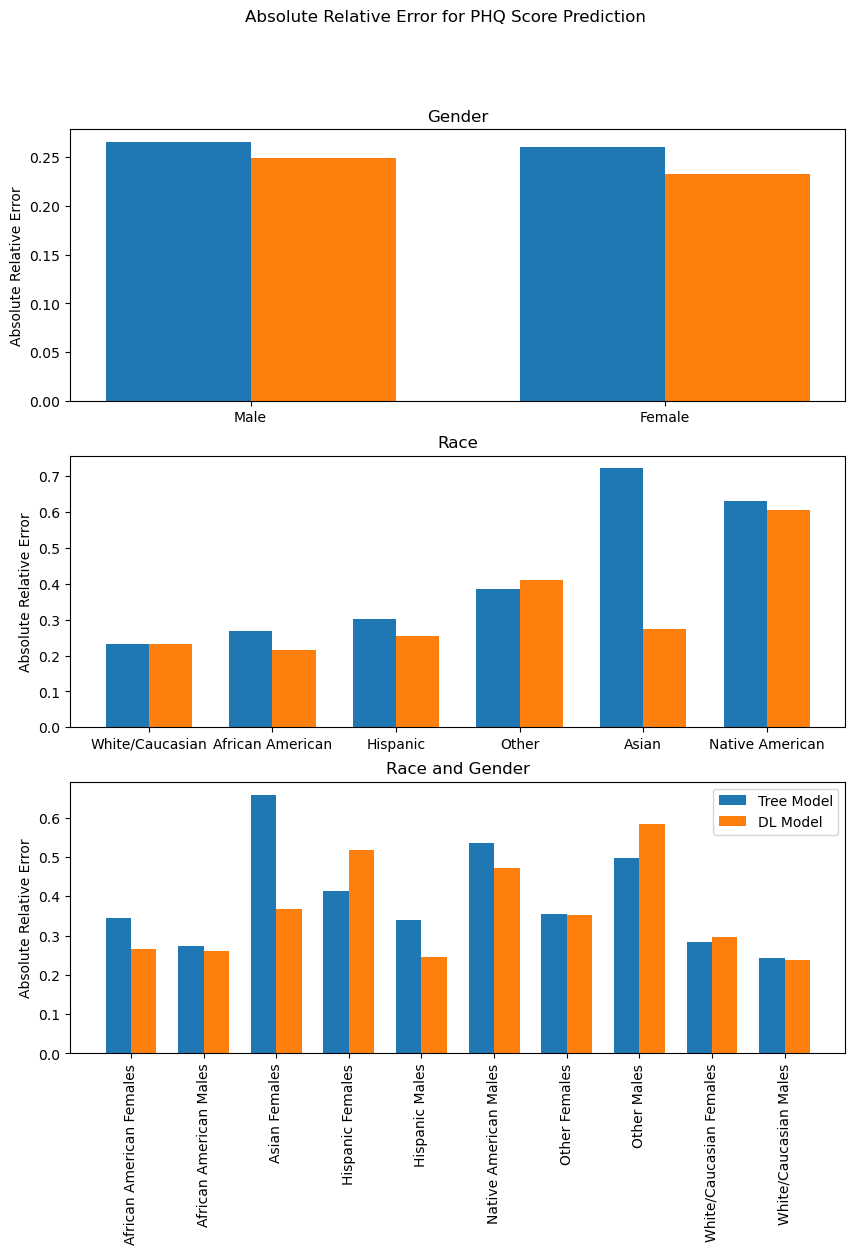

In [235]:
#iterate over each gender/race group and calculate the mean absolute error

grouped = predDF.groupby(["RaceData", "genderData"])

genderTreeErrors = []
genderDLErrors = []

for gender in predDF["genderData"].unique():

    if len(predDF[predDF["genderData"] == gender]) < 2:
        continue


    treeError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_tree"], predDF[predDF["genderData"] == gender]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_dl"], predDF[predDF["genderData"] == gender]["phq_score_x"])

    genderTreeErrors.append(treeError[0])
    genderDLErrors.append(dlError[0])



    print(f"For {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")

raceCat = []
raceTreeErrors = []
raceDLErrors = []

for race in predDF["RaceData"].unique():

    if len(predDF[predDF["RaceData"] == race]) < 2:
        continue

    treeError = absRelErr(predDF[predDF["RaceData"] == race]["phq_score_tree"], predDF[predDF["RaceData"] == race]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["RaceData"] == race]["phq_score_dl"], predDF[predDF["RaceData"] == race]["phq_score_x"])

    raceCat.append(race)
    raceTreeErrors.append(treeError[0])
    raceDLErrors.append(dlError[0])

    print(f"For {race} participants the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


raceGenderCat = []
raceGenderTreeErrors = []
raceGenderDLErrors = []

for (race, gender), group in grouped:

    if(race == "Asian" and gender == "Male"):
        continue

    if len(group) < 2:
        continue

    treeError = absRelErr(group["phq_score_tree"], group["phq_score_x"])
    dlError = absRelErr(group["phq_score_dl"], group["phq_score_x"])

    raceGenderCat.append(f"{race} {gender}s")
    raceGenderTreeErrors.append(treeError[0])
    raceGenderDLErrors.append(dlError[0])

    #print the results
    #print(f"For {race} {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


#plot the results as a bar chart

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(10, 12))
fig.suptitle("Absolute Relative Error for PHQ Score Prediction")

# Define the width of the bars
bar_width = 0.35

# Create positions for the bars
index = np.arange(len(genderTreeErrors))

# Plot Gender
ax[0].bar(index, genderTreeErrors, bar_width, label="Tree Model")
ax[0].bar(index + bar_width, genderDLErrors, bar_width, label="DL Model")
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(["Male", "Female"])
ax[0].set(ylabel="Absolute Relative Error")
ax[0].set_title("Gender")

# Plot Race
index = np.arange(len(raceTreeErrors))
ax[1].bar(index, raceTreeErrors, bar_width, label="Tree Model")
ax[1].bar(index + bar_width, raceDLErrors, bar_width, label="DL Model")
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(raceCat)
ax[1].set(ylabel="Absolute Relative Error")
ax[1].set_title("Race")

# Plot Race and Gender
index = np.arange(len(raceGenderTreeErrors))
ax[2].bar(index, raceGenderTreeErrors, bar_width, label="Tree Model")
ax[2].bar(index + bar_width, raceGenderDLErrors, bar_width, label="DL Model")
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(raceGenderCat)
ax[2].set(ylabel="Absolute Relative Error")
ax[2].set_title("Race and Gender")
# Rotate the x labels 90 degrees
plt.xticks(rotation=90)

plt.legend()
plt.show()






In [205]:
#Repeat above but remove the 50 most correlated features of race and gender


raceDF = final_df.drop(["phq_score", "condition", "participant_id", "genderData"], axis=1)

targetRace = raceDF.pop("RaceData")

raceCorr = []

for i, (cols) in enumerate(raceDF.columns):

    corr, p = pearsonr(raceDF[cols], targetRace)
    if np.isnan(corr):
        corr = 0
    raceCorr.append(corr)


genderDF = final_df.drop(["phq_score", "condition", "participant_id", "RaceData"], axis=1).dropna()

targetGender = genderDF.pop("genderData")

genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    if np.isnan(corr):
        corr = 0
    genderCorr.append(corr)



In [206]:
#Looking for subgroup accuracy using the best model

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqDF = final_df.drop(["race", "condition", "genderData"], axis=1)

targetPHQ = pd.DataFrame([phqDF.pop("participant_id"), phqDF.pop("phq_score").astype(int)]).T

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]["phq_score"]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))




minDLReNumFeatures = 125
minTreeReNumFeatures = 50


nIdxTree = top_n_idx(phqCorr, minTreeReNumFeatures)
nColsTree = phqDF.columns[nIdxTree]

nIdxDL = top_n_idx(phqCorr, minDLReNumFeatures)
nColsDL = phqDF.columns[nIdxDL]


nIdxTreeRace = top_n_idx(raceCorr, 50)
nColsTreeRace = phqDF.columns[nIdxTreeRace]

nIdxDLRace = top_n_idx(raceCorr, 50)
nColsDLRace = phqDF.columns[nIdxDLRace]

nIdxTreeGender = top_n_idx(genderCorr, 50)
nColsTreeGender = phqDF.columns[nIdxTreeGender]

nIdxDLGender = top_n_idx(genderCorr, 50)
nColsDLGender = phqDF.columns[nIdxDLGender]

#Remove the race and gender columns from the phq columns
nColsTree = [x for x in nColsTree if x not in nColsTreeRace]
nColsDL = [x for x in nColsDL if x not in nColsDLRace]

nColsTree = [x for x in nColsTree if x not in nColsTreeGender]
nColsDL = [x for x in nColsDL if x not in nColsDLGender]

# Iterate through the folds and actually store the predicition for each participant

predictionsDF = pd.DataFrame(columns=["participant_id", "phq_score_tree", "phq_score_dl"])

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):

    #match the predictions with the participant ID

    train_fold_tree = train_fold[nColsTree]
    test_fold_tree = test_fold[nColsTree]

    
    # train XGBoost model
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(train_fold_tree, train_target_fold)


    predTree = xgb_regressor.predict(test_fold_tree)
    
    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_tree"] = predTree


    # train DL model

    train_fold_dl = train_fold[nColsDL]
    test_fold_dl = test_fold[nColsDL]

    FNN = getDLModel(train_fold_dl.shape[1])

    FNN.fit(train_fold_dl.astype(float), train_target_fold.astype(float), epochs=100, verbose=0)

    predDL = FNN.predict(test_fold_dl).flatten()

    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_dl"] = predDL

    predictionsDF = pd.concat([predictionsDF, test_target_fold], axis=0)

# predDF
print(predictionsDF.head(30))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
    participant_id  phq_score_tree  phq_score_dl phq_score
4              390        4.453957      1.931108         9
10             397       15.797576      1.969864         5
12             400       10.784444      1.995482         7
16             404        2.403605      1.845200         0
18             406        3.434948      1.896241         2
19             407        2.475428      1.890624         3
26             414        3.305424      1.928542        16
27             415       12.903002      1.959112         3
31             419       12.342867      1.941219         3
40             428        1.473874      1.876490         0
42             430       12.736128      1.854320         3
44             432        4.965662      1.910602         1
45             433        2.838801      1

In [207]:
predictionsDF = predictionsDF.sort_values(by=["participant_id"])

#combine the predictions with the demographic data

#create a dataframe to store the predictions. Has participant ID, race, gender, PHQ score, and the predicted PHQ score for both models
predDF = final_df[["participant_id", "RaceData", "genderData", "phq_score"]]

predDF = pd.merge(predDF, predictionsDF, on="participant_id")

#map race from number to label
raceMap = {
    1: "African American",
    2: "Asian",
    3: "White/Caucasian",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Oth Pacific Islander",
    7: "Other"
}

genderMap = {
    1: "Male",
    2: "Female"
}

#apply mapping to dataframe
predDF["RaceData"] = predDF["RaceData"].astype(int).map(raceMap)
predDF["genderData"] = predDF["genderData"].map(genderMap)

print(predDF.head(30))


   participant_id          RaceData genderData  phq_score_x  phq_score_tree  \
0             386   White/Caucasian     Female           11        6.253038   
1             387  African American       Male            2        2.139851   
2             388          Hispanic       Male           17        3.914337   
3             389  African American       Male           14        0.864258   
4             390   White/Caucasian       Male            9        4.453957   
5             391          Hispanic     Female            9        3.210843   
6             392   White/Caucasian     Female            1        6.958161   
7             393          Hispanic       Male            2        2.185115   
8             395          Hispanic     Female            7        4.567372   
9             396   White/Caucasian       Male            5        4.945437   
10            397          Hispanic       Male            5       15.797576   
11            399             Other     Female      

For Females the tree model had an absolute relative error of 0.2649443095066418 and the DL model had an absolute relative error of 0.2485242268414528
For Males the tree model had an absolute relative error of 0.25979759033820393 and the DL model had an absolute relative error of 0.23244327736918724
For White/Caucasian participants the tree model had an absolute relative error of 0.23087281719237177 and the DL model had an absolute relative error of 0.23143174660894053
For African American participants the tree model had an absolute relative error of 0.2672034036990001 and the DL model had an absolute relative error of 0.21507128702686873
For Hispanic participants the tree model had an absolute relative error of 0.3016428848638892 and the DL model had an absolute relative error of 0.25468344901773066
For Other participants the tree model had an absolute relative error of 0.38519045591354373 and the DL model had an absolute relative error of 0.40929588794708255
For Asian participants the

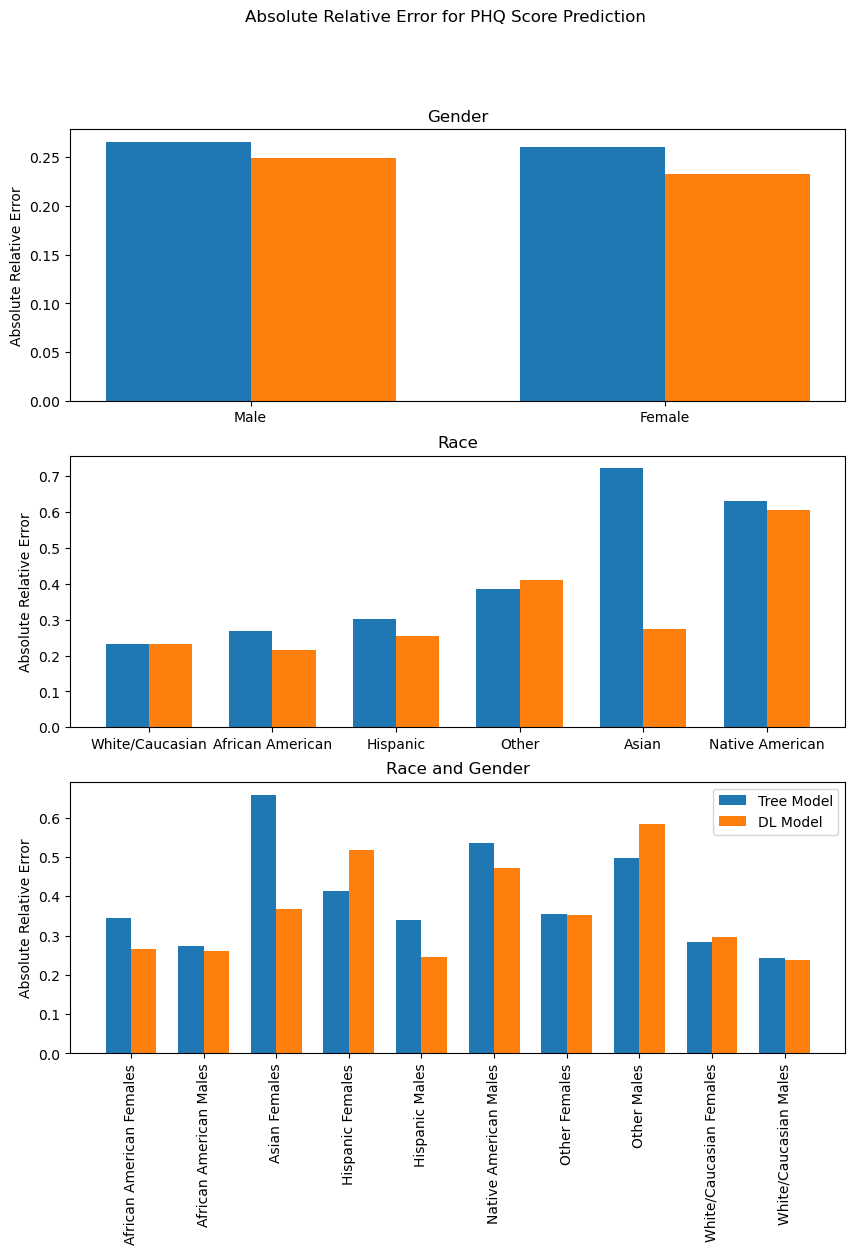

In [223]:
#iterate over each gender/race group and calculate the mean absolute error

grouped = predDF.groupby(["RaceData", "genderData"])

genderTreeErrors = []
genderDLErrors = []

for gender in predDF["genderData"].unique():

    if len(predDF[predDF["genderData"] == gender]) < 2:
        continue


    treeError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_tree"], predDF[predDF["genderData"] == gender]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_dl"], predDF[predDF["genderData"] == gender]["phq_score_x"])

    genderTreeErrors.append(treeError[0])
    genderDLErrors.append(dlError[0])



    print(f"For {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")

raceCat = []
raceTreeErrors = []
raceDLErrors = []

for race in predDF["RaceData"].unique():

    if len(predDF[predDF["RaceData"] == race]) < 2:
        continue

    treeError = absRelErr(predDF[predDF["RaceData"] == race]["phq_score_tree"], predDF[predDF["RaceData"] == race]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["RaceData"] == race]["phq_score_dl"], predDF[predDF["RaceData"] == race]["phq_score_x"])

    raceCat.append(race)
    raceTreeErrors.append(treeError[0])
    raceDLErrors.append(dlError[0])

    print(f"For {race} participants the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


raceGenderCat = []
raceGenderTreeErrors = []
raceGenderDLErrors = []

for (race, gender), group in grouped:

    if(race == "Asian" and gender == "Male"):
        continue

    if len(group) < 2:
        continue

    treeError = absRelErr(group["phq_score_tree"], group["phq_score_x"])
    dlError = absRelErr(group["phq_score_dl"], group["phq_score_x"])

    raceGenderCat.append(f"{race} {gender}s")
    raceGenderTreeErrors.append(treeError[0])
    raceGenderDLErrors.append(dlError[0])

    #print the results
    #print(f"For {race} {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


#plot the results as a bar chart

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(10, 12))
fig.suptitle("Absolute Relative Error for PHQ Score Prediction")

# Define the width of the bars
bar_width = 0.35

# Create positions for the bars
index = np.arange(len(genderTreeErrors))

# Plot Gender
ax[0].bar(index, genderTreeErrors, bar_width, label="Tree Model")
ax[0].bar(index + bar_width, genderDLErrors, bar_width, label="DL Model")
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(["Male", "Female"])
ax[0].set(ylabel="Absolute Relative Error")
ax[0].set_title("Gender")

# Plot Race
index = np.arange(len(raceTreeErrors))
ax[1].bar(index, raceTreeErrors, bar_width, label="Tree Model")
ax[1].bar(index + bar_width, raceDLErrors, bar_width, label="DL Model")
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(raceCat)
ax[1].set(ylabel="Absolute Relative Error")
ax[1].set_title("Race")

# Plot Race and Gender
index = np.arange(len(raceGenderTreeErrors))
ax[2].bar(index, raceGenderTreeErrors, bar_width, label="Tree Model")
ax[2].bar(index + bar_width, raceGenderDLErrors, bar_width, label="DL Model")
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(raceGenderCat)
ax[2].set(ylabel="Absolute Relative Error")
ax[2].set_title("Race and Gender")
# Rotate the x labels 90 degrees
plt.xticks(rotation=90)

plt.legend()
plt.show()




